In [1]:
! pip install import_ipynb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.4 MB/s eta 0:00:00


tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])
Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)
tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)
Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBac

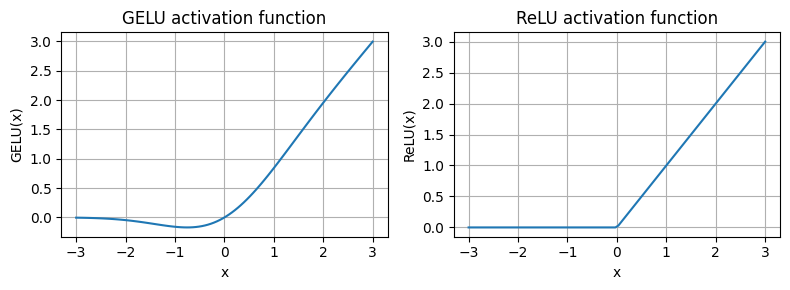

layers.0.0.weight has gradient mean of 0.0002017411752603948
layers.1.0.weight has gradient mean of 0.00012011770741082728
layers.2.0.weight has gradient mean of 0.0007152436883188784
layers.3.0.weight has gradient mean of 0.0013988509308546782
layers.4.0.weight has gradient mean of 0.005049603525549173
layers.0.0.weight has gradient mean of 0.22186803817749023
layers.1.0.weight has gradient mean of 0.20709280669689178
layers.2.0.weight has gradient mean of 0.3292388916015625
layers.3.0.weight has gradient mean of 0.26677730679512024
layers.4.0.weight has gradient mean of 1.326806664466858
Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3612,  0.4223, -0.0712,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1793, -0.5660, -0.9486,  ...,  0.0477,  0.5181, -0.3169],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1017, -0.4326, -0.2553],
         [-1.0076,  0.3419, -0.1190,  ...,  0.7195,  0.4023,  0.05

In [2]:
import import_ipynb
from Implementing_GPT_2_model_from_scratch import GPTModel,generate_text_simple # Importing the previous model(Ignore the output)

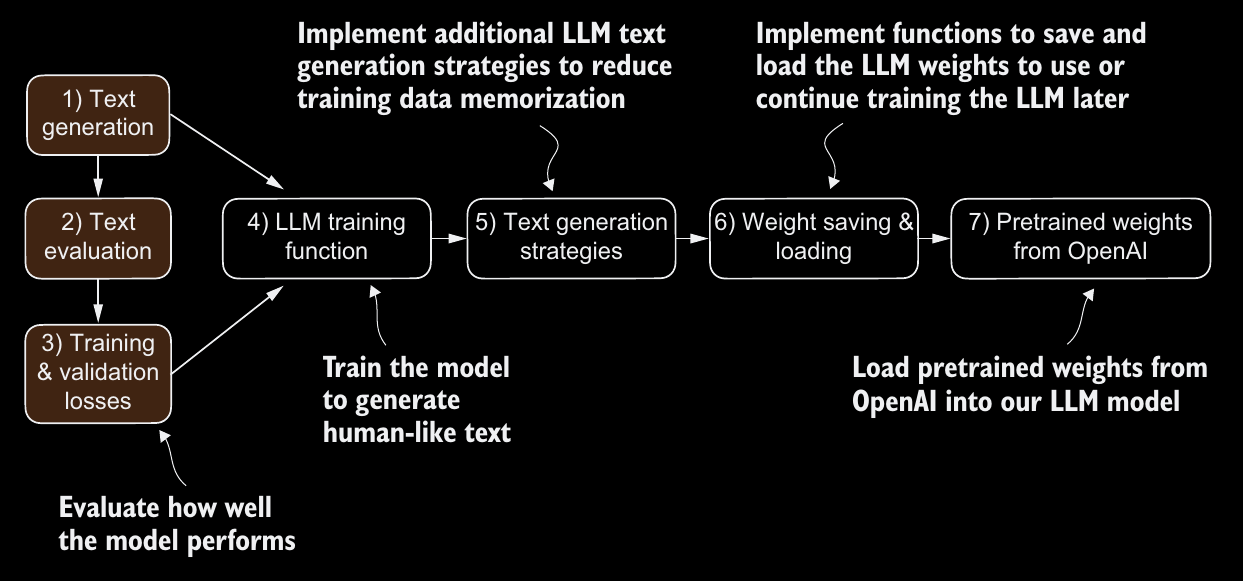

Things we will be working on in this file

In [3]:
import torch
GPT_CONFIG_124M = {
    "vocab_size":50257,
    "context_length":256,
    "embed_dim": 768,
    "n_heads":12,
    "n_layers":12,
    "drop_rate":0.1,
    "qkv_bias":False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention1(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention1(
        (W_query)

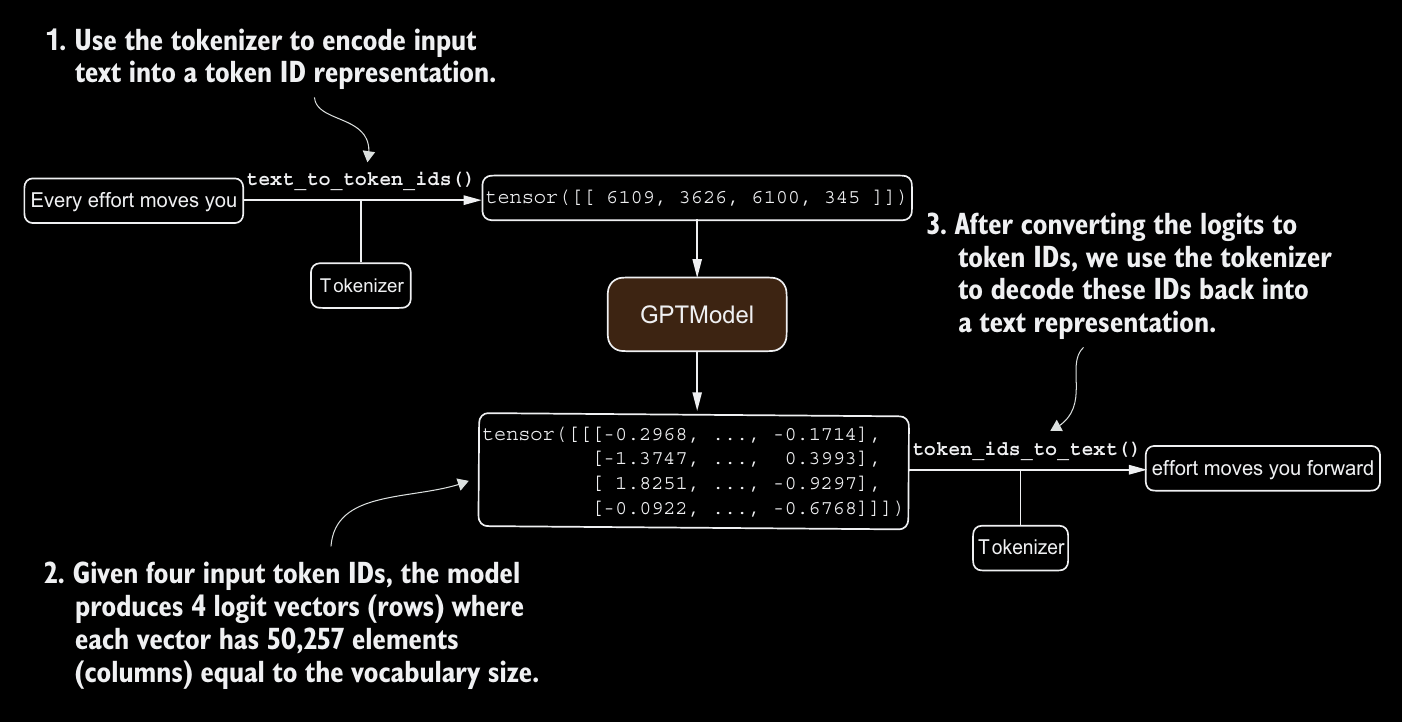

In [4]:
import tiktoken
def text_to_token_ids(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special = {'<|endoftext|>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)
  return encoded_tensor
def token_ids_to_text(token_ids, tokenizer):
  decoded = tokenizer.decode(token_ids.squeeze(0).tolist())
  return decoded

In [5]:
start_context = "I am Alexander the great"
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens = 10,
    context_size = GPT_CONFIG_124M["context_length"]
)

In [6]:
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 I am Alexander the great Royal cancechildanse fray moisture Gael Editing dreaming travelling


## Calculating the text generation loss

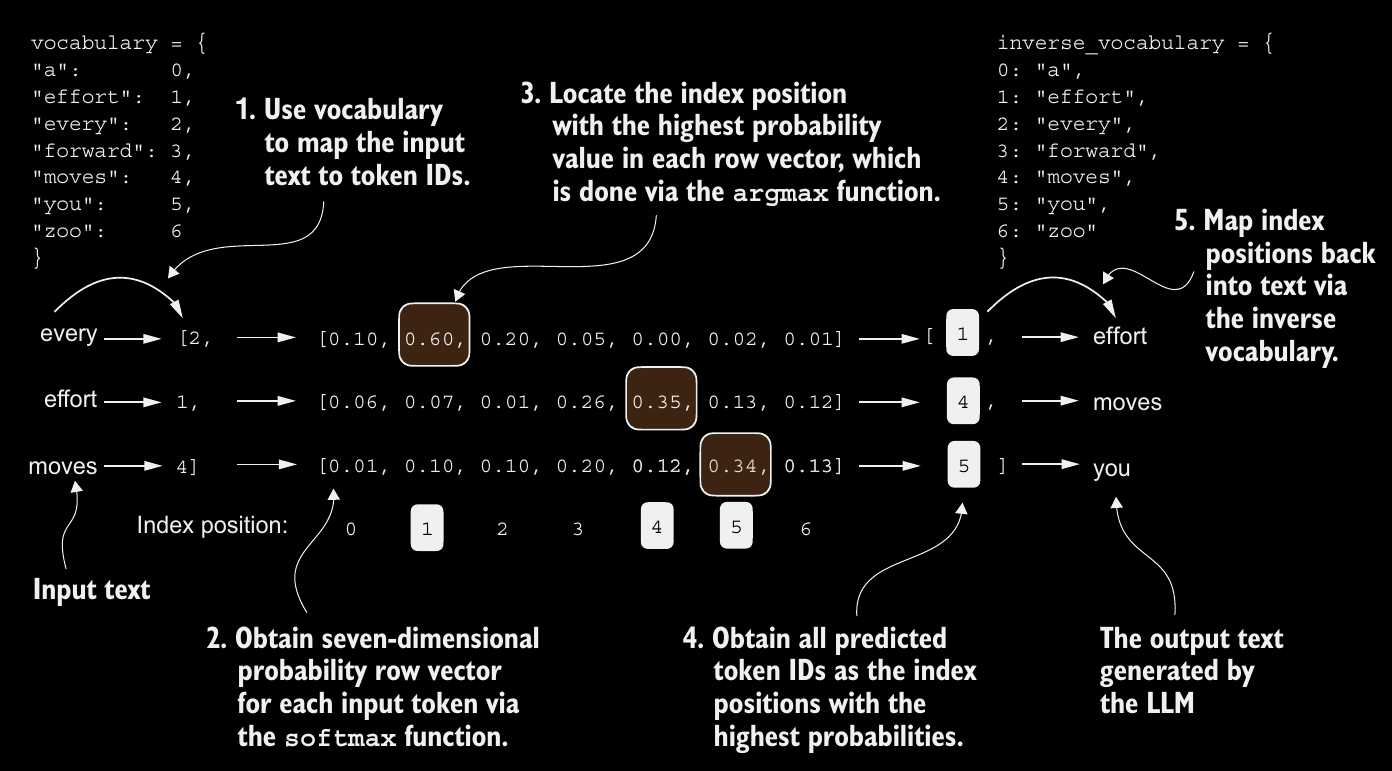

 For each of the three input tokens, shown on the left, we compute a vector containing probability
scores corresponding to each token in the vocabulary. The index position of the highest probability score in each
vector represents the most likely next token ID. These token IDs associated with the highest probability scores
are selected and mapped back into a text that represents the text generated by the model.

Here we explore techniques for numerically accessing text quality generation during training by calculating text generation loss. The above image shows the overall flow of the input text to LLM-generated text. We need to peerform these same initial steps before we can compute a loss that measures the generated text quality

In [7]:
inputs = torch.tensor([[16833, 3626, 6100], #["Every effor moves",
                       [40, 1107, 588]])    # "I really like"]
targets = torch.tensor([[3626, 6100, 345 ], # [" effort moves you",
                        [1107, 588, 11311]])# " really like chocolate"]

In [8]:
with torch.no_grad(): # Disables gradient tracking since we are not training yet
  logits = model(inputs)
probas = torch.softmax(logits, dim = -1) # Probability of each token in vocabulary
print(probas.shape) # (batch size, number_of_tokens, vocab_size)
print(probas)

torch.Size([2, 3, 50257])
tensor([[[1.8851e-05, 1.5173e-05, 1.1687e-05,  ..., 2.2408e-05,
          6.9776e-06, 1.8775e-05],
         [9.1574e-06, 1.0062e-05, 7.8784e-06,  ..., 2.9089e-05,
          6.0105e-06, 1.3569e-05],
         [2.9875e-05, 8.8504e-06, 1.5741e-05,  ..., 3.5458e-05,
          1.4094e-05, 1.3525e-05]],

        [[1.2561e-05, 2.0537e-05, 1.4331e-05,  ..., 1.0388e-05,
          3.4784e-05, 1.4238e-05],
         [7.2733e-06, 1.7863e-05, 1.0564e-05,  ..., 2.1206e-05,
          1.1390e-05, 1.5558e-05],
         [2.9495e-05, 3.3605e-05, 4.1032e-05,  ..., 6.5251e-06,
          5.8202e-05, 1.3697e-05]]])


In [9]:
token_ids = torch.argmax(probas, dim = -1, keepdim = True) # returns the index containing highest probability
print("Token_ids:\n", token_ids) # We get 2 set of outputs with predicted token ids

Token_ids:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [10]:
print(f"Target batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:" f"{token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Target batch 1:  effort moves you
Outputs batch 1: Armed heNetflix


The model produces random text that is different from the target text because it has not been trained yet.We now want to evaluate the performance of the model’s generated text numerically via a loss

The model training aims to increase the softmax probability in the index positions corresponding to the correct target token IDs. This softmax probability is also used in evaluation metric

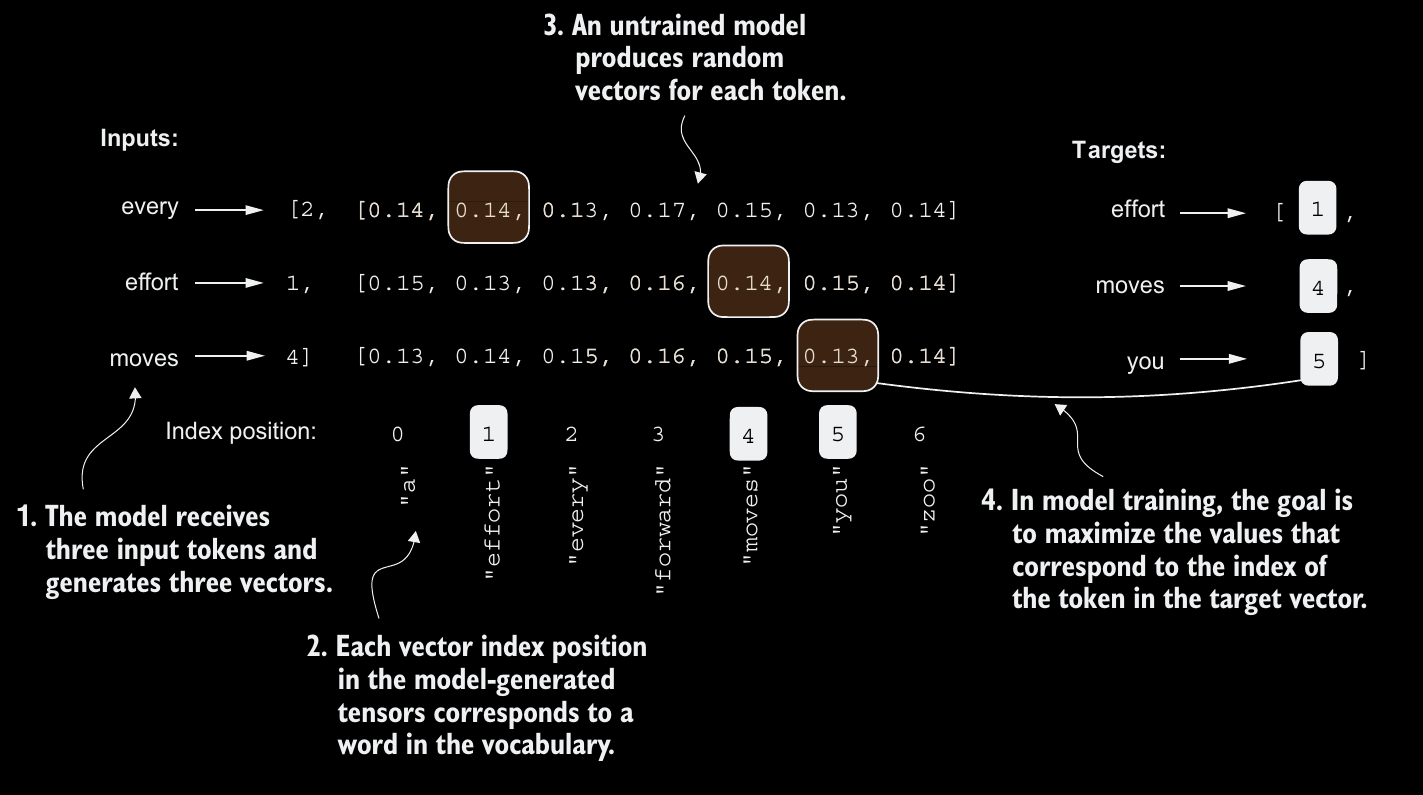

In [11]:
# For each token we can print the initial softmax probability scores corresponding to the target tokens.
text_idx = 0
target_probas_1 = probas[text_idx, [0,1,2], targets[text_idx]]
print("Text 1: ", target_probas_1)

Text 1:  tensor([7.4536e-05, 3.1061e-05, 1.1563e-05])


In [12]:
text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 2: tensor([1.0337e-05, 5.6771e-05, 4.7559e-06])


The goal of training the LLM is to maximize the likelihood of the correct token, which involves increasing the probability relative to other token

In [13]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7765, -12.2561])


In [14]:
average_log_probas = torch.mean(log_probas)
print(average_log_probas)

tensor(-10.7940)


In [15]:
neg_avg_log_probability = average_log_probas*-1
print(neg_avg_log_probability)

tensor(10.7940)


In [16]:
print("Logits shape: ", logits.shape)
print("Targets shape: ", targets.shape)

Logits shape:  torch.Size([2, 3, 50257])
Targets shape:  torch.Size([2, 3])


In [17]:
# For cross entropy loss functio we want to flatten these tensors by combining them over the batch dimensions
logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten()
print("Flatten logits: ", logits_flat.shape)
print("Flatten_targets", targets_flat.shape)

Flatten logits:  torch.Size([6, 50257])
Flatten_targets torch.Size([6])


In [18]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


In [19]:
file_path = "/content/Alexander_the_Great.txt"
with open(file_path, "r", encoding = "utf-8") as file:
  text_data = file.read()

In [20]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters: ", total_characters)
print("Tokens: ", total_tokens)

Characters:  87251
Tokens:  19139


### Dividing into training/Validation set

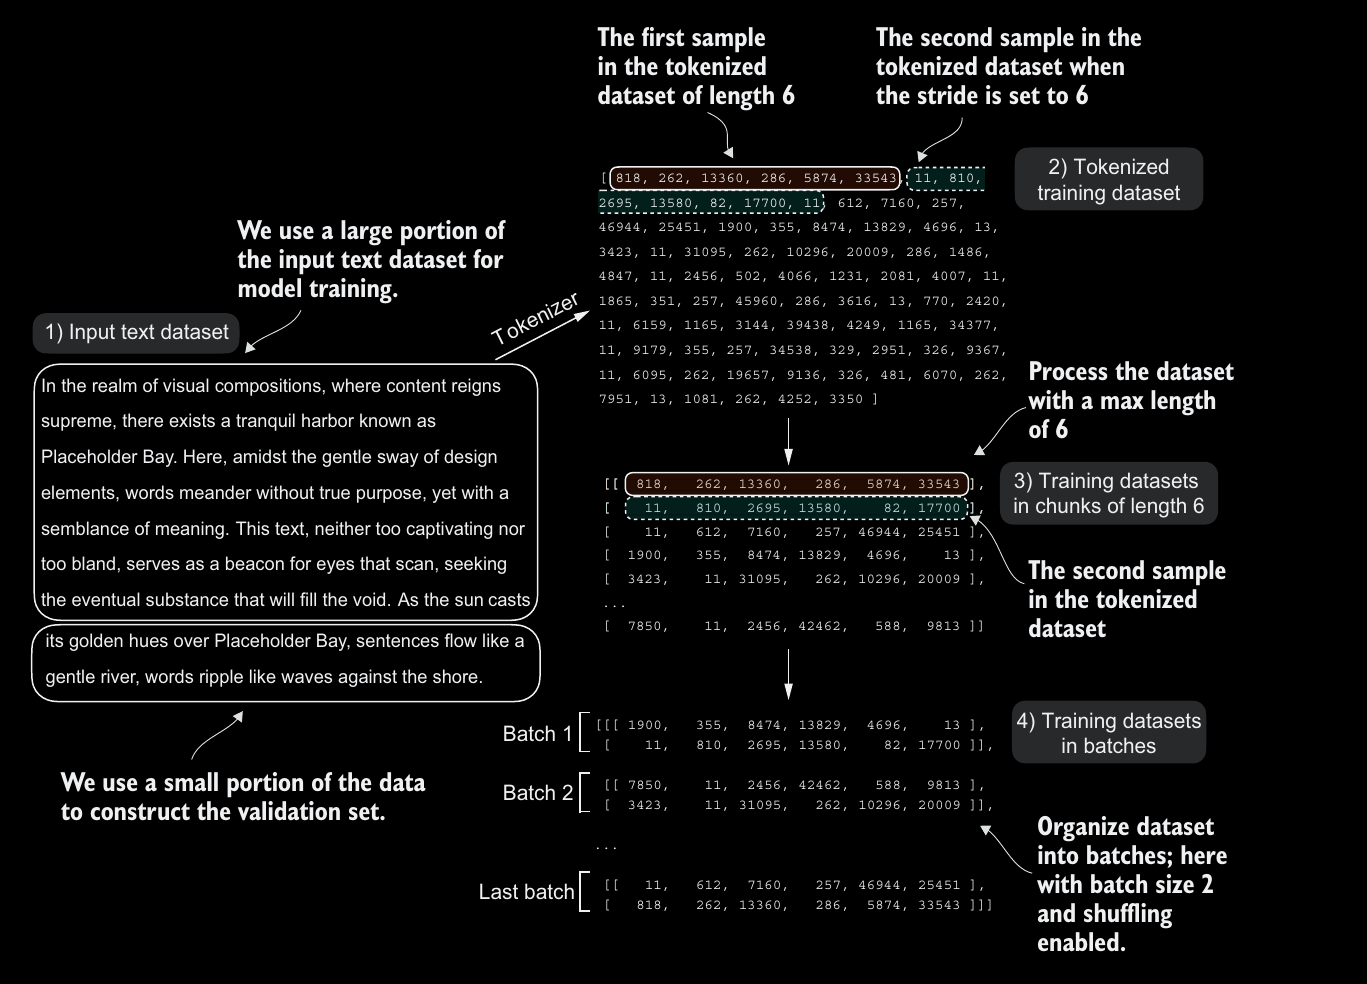

In [21]:
train_ratio = 0.90
split_idx = int(train_ratio*len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [22]:
from Working_with_text_data import create_dataloader_v1
torch.manual_seed(123)

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g
['Hello', 'world', '.', 'This', ',', 'Is', 'this', '--', 'a', 'test', '.']
4690
['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']
1130
('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle

In [23]:
train_loader = create_dataloader_v1(
    train_data,
    batch_size = 4,
    max_length = GPT_CONFIG_124M["context_length"],
    stride = GPT_CONFIG_124M["context_length"],
    drop_last = False,
    shuffle = True,
    num_workers = 0
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=4,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [24]:
print("Train Loader:")
for x, y in train_loader:
  print(x.shape, y.shape)

Train Loader:
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([3, 256]) torch.Size([3, 256])


In [25]:
print("\nValidation loader:")
for x, y in val_loader:
  print(x.shape, y.shape)


Validation loader:
torch.Size([4, 256]) torch.Size([4, 256])
torch.Size([3, 256]) torch.Size([3, 256])


the input
data (x) and target data (y) have the same shape (the batch size times the number of
tokens in each batch) since the targets are the inputs shifted by one position

In [26]:
def calc_loss_batch(input_batch, target_batch, model,device):
  input_batch = input_batch.to(device) # Transfer to the given device allows us to transfer the data to GPU
  target_batch = target_batch.to(device)
  logits = model(input_batch)
  loss = torch.nn.functional.cross_entropy(
      logits.flatten(0,1), target_batch.flatten()
  )
  return loss

In [27]:
def calc_loss_loader(data_loader, model, device, num_batches = None):
  total_loss = 0
  if len(data_loader) == 0:
    return float("nan")
  elif num_batches is None:
    num_batches = len(data_loader) # Iterates over all the batches if no fixed num_batches is specified
  else:
    num_batches = min(num_batches,len(data_loader))
  for i, (input_batch,target_batch) in enumerate(data_loader):
    if i< num_batches:
      loss = calc_loss_batch(
          input_batch, target_batch,model, device
      )
      total_loss += loss.item() # Sums loss for each batch
    else:
      break
  return total_loss/num_batches # Average loss over all the batches

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # if you have machines with a CUDA-supported GPU, the LLM will train on the GPU without making any changes to the code.
with torch.no_grad(): # Disbales gradient tracking for efficiency coz we are not training yet
  train_loss = calc_loss_loader(train_loader, model, device) # Via device setting we ensure that the data is loaded into the same device as the model
  val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss: ", train_loss)
print("Validation loss: ", val_loss)

Training loss:  10.992086971507353
Validation loss:  10.979626178741455


### Training

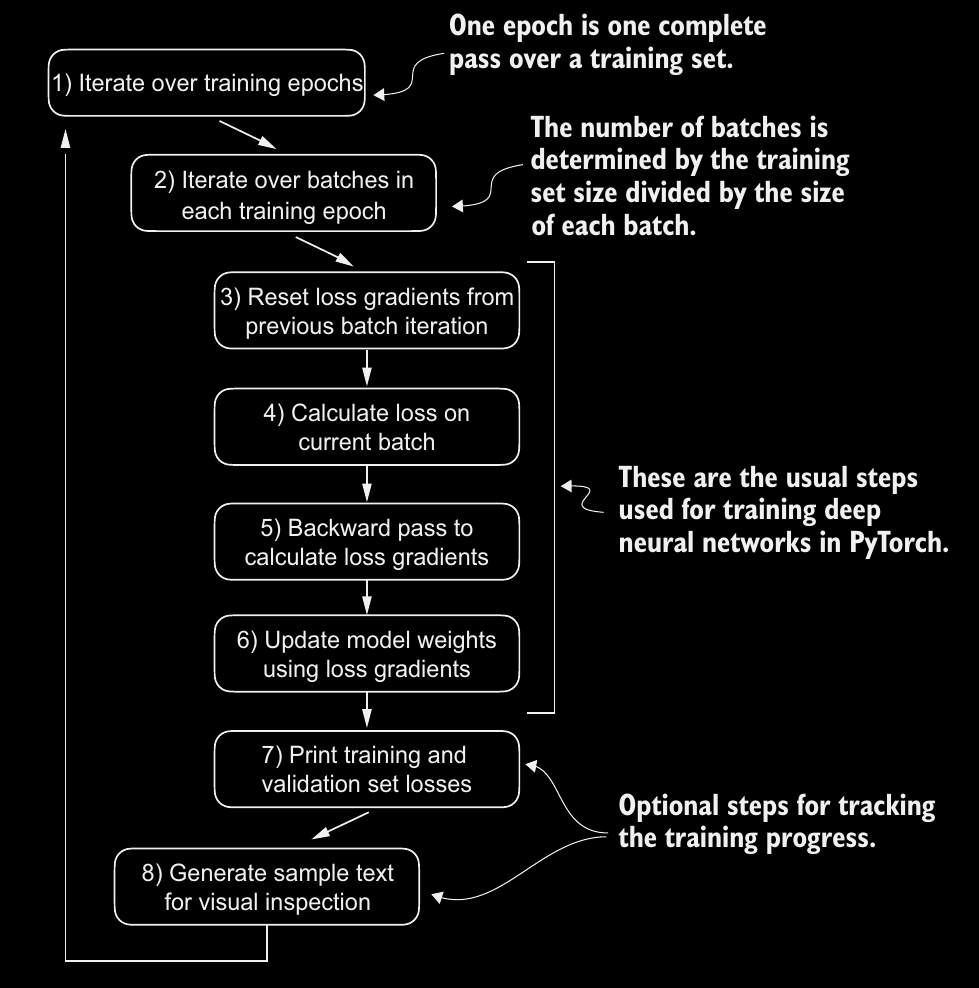

In [29]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [31]:
import time
start_time = time.time()
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(), lr = 0.0004, weight_decay=0.1
)
num_epochs = 30
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.760, Val loss 10.005
Ep 1 (Step 000005): Train loss 8.296, Val loss 8.631
Ep 1 (Step 000010): Train loss 7.272, Val loss 7.895
Ep 1 (Step 000015): Train loss 6.930, Val loss 7.731
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep 2 (Step 000020): Train loss 6.665, Val loss 7.754
Ep 2 (Step 000025): Train loss 6.486, Val loss 7.760
Ep 2 (Step 000030): Train loss 6.423, Val loss 7.777
Every effort moves you, and the a, Alexander, Alexander, and the a, and the a, and the a, and the a, and the a, and the a, Alexander, and the a, Alexander, and the a, and the a, and
Ep 3 (Step 000035): Train loss 6.395, Val loss 7.730
Ep 3 (Step 000040): Train loss 6.486, Val loss 7.772
Ep 3 (Step 000045): Train loss 6.320, Val loss 7.693
Ep 3 (Step 000050): Train loss 6.220, Val loss 7.683
Every effort moves you, and Alexander's, and the A, and the Persian, and the Persian, and the Persian, and the Persian, and the Alexander's, and the Alexander's,

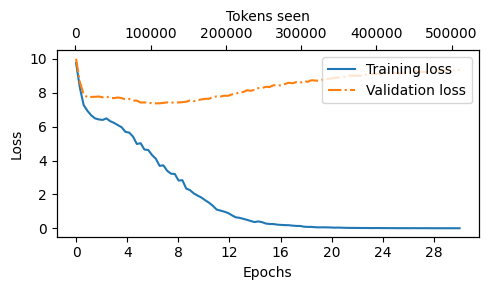

In [32]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)